In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# LightGBM for modeling
from lightgbm import LGBMRegressor

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

# Understanding the requirement 

https://www.kaggle.com/competitions/playground-series-s4e9

#### Goal

> The goal of this competition is to predict the price of used cars based on various attributes.

#### Evaluation

> Root Mean Squared Error (RMSE)

The root mean square error (RMSE) measures the average difference between a statistical model’s predicted values and the actual values. Mathematically, it is the standard deviation of the residuals. Residuals represent the distance between the regression line and the data points.

[Reference](https://statisticsbyjim.com/regression/root-mean-square-error-rmse/#:~:text=The%20root%20mean%20square%20error%20(RMSE)%20measures%20the%20average%20difference,line%20and%20the%20data%20points.)

#### Submission File

> For each id in the test set, we must predict the price of the car. 

# Loading data

In [2]:
sample_submission_path = '/kaggle/input/playground-series-s4e9/sample_submission.csv'
test_path = '/kaggle/input/playground-series-s4e9/test.csv'
train_path = '/kaggle/input/playground-series-s4e9/train.csv'

In [3]:
sample_submission = pd.read_csv(sample_submission_path)
test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

In [4]:
sample_submission.head(5)

,id,price
0,188533,43878.016
1,188534,43878.016
2,188535,43878.016
3,188536,43878.016
4,188537,43878.016


**The submission format contains two columns: id and price.**

In [5]:
train_columns = set(train.columns)
test_columns = set(test.columns)

In [6]:
len(train.columns)

13

In [7]:
len(test.columns)

12

In [8]:
common_columns = train_columns.intersection(test_columns)
common_columns

{'accident',
 'brand',
 'clean_title',
 'engine',
 'ext_col',
 'fuel_type',
 'id',
 'int_col',
 'milage',
 'model',
 'model_year',
 'transmission'}

In [9]:
different_columns = train_columns.difference(test_columns)
different_columns

{'price'}

We have observed that **price** is the only column present in the train dataset but not in the test dataset. However, all other columns are the same in both the train and test datasets.

# Observing data

### Missing values

In [10]:
train.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

### Info

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


### Duplication

In [12]:
duplicate = train[train.duplicated()]

In [13]:
duplicate

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price


# Data visulization

ID numbers are no meaningful numerical values 

In [14]:
categorical_columns = ['id','brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title','model_year']
numerical_columns = ['price','milage']

In [15]:
mean_milage = train.groupby('brand')['milage'].mean()
mean_price = train.groupby('brand')['price'].mean()

mean_milage_price = pd.DataFrame({
    'Brand': mean_milage.index,
    'mean_milage': mean_milage.values,
    'mean_price': mean_price.values
})

mean_milage_price = mean_milage_price.sort_values(by = ['mean_milage'])

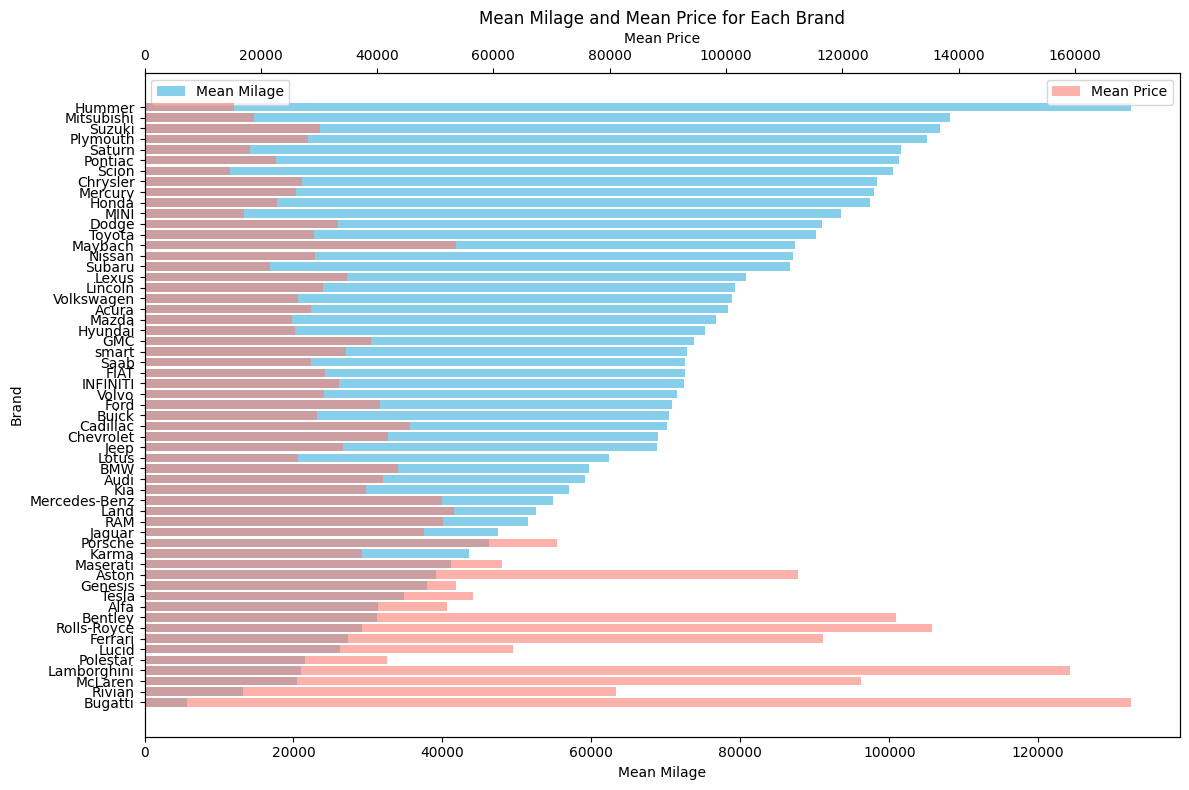

In [16]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for mean_milage
bars1 = ax1.barh(mean_milage_price['Brand'], mean_milage_price['mean_milage'], color='skyblue', label='Mean Milage')

# Create a second y-axis for mean_price
ax2 = ax1.twiny()
bars2 = ax2.barh(mean_milage_price['Brand'], mean_milage_price['mean_price'], color='salmon', label='Mean Price', alpha=0.6)

# Set labels and title
ax1.set_xlabel('Mean Milage')
ax1.set_ylabel('Brand')
ax2.set_xlabel('Mean Price')
ax1.set_title('Mean Milage and Mean Price for Each Brand')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Generally, the higher the mileage, the lower the car's value. Conversely, the higher the car's value, the lower the mileage.

In [17]:
print(f"We can see that the car model years range from {train['model_year'].min()} to {train['model_year'].max()}.")

We can see that the car model years range from 1974 to 2024.


In [18]:
model_year_counts = train['model_year'].value_counts().sort_index()
model_year_counts = pd.DataFrame({
    'model_year': model_year_counts.index,
    'count': model_year_counts.values
})

In [19]:
model_year_counts

,model_year,count
0,1974,12
1,1992,14
2,1993,140
3,1994,92
4,1995,102
5,1996,189
6,1997,312
7,1998,343
8,1999,554
9,2000,558


      Decade   Count
0  1970-1979      12
1  1980-1989       0
2  1990-1999    2304
3  2000-2009   30218
4  2010-2019  113121
5  2020-2029   42878


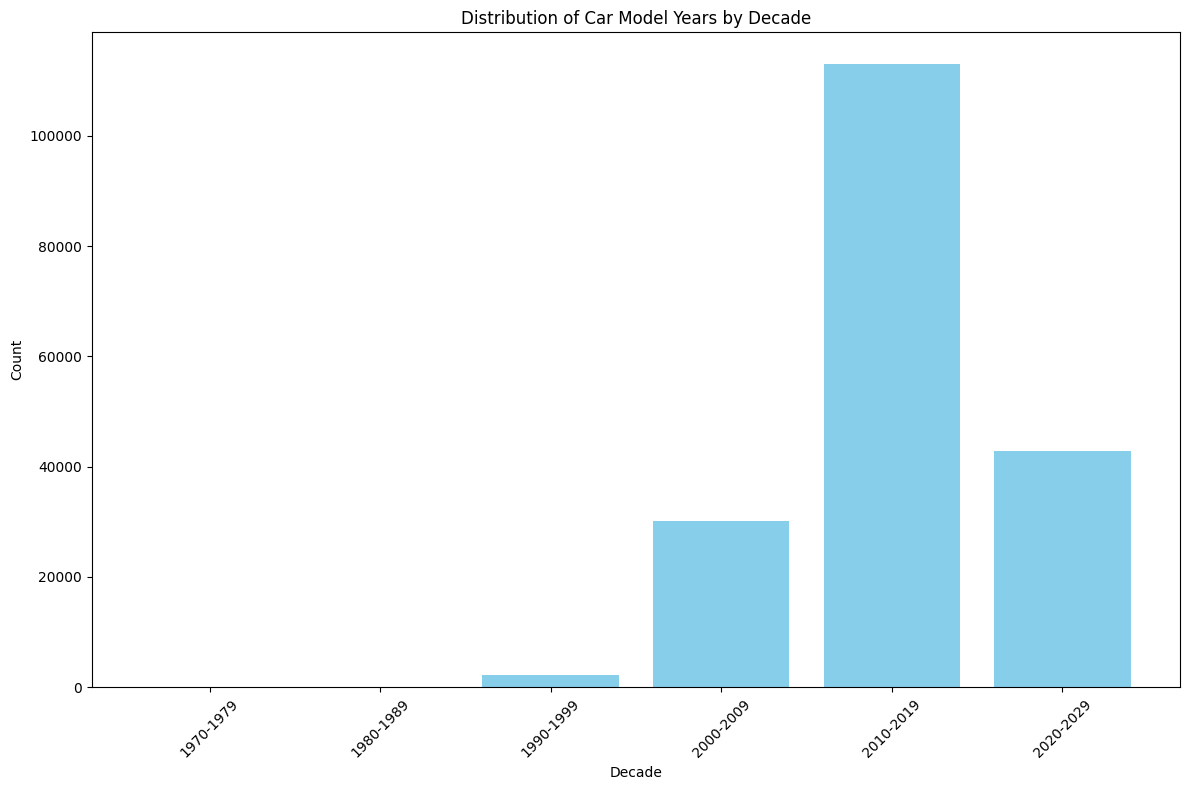

In [20]:
# Define bins for every ten years, ensuring coverage from 1970 to 2024
bins = list(range(1970, 2035, 10))  # Extending to 2035 to cover the last decade
labels = [f'{year}-{year + 9}' for year in bins[:-1]]  # Labels for each decade

# Temporarily categorize data into bins and create a new Series
decade_series = pd.cut(train['model_year'], bins=bins, labels=labels, right=True)

# Count occurrences in each decade
decade_counts = decade_series.value_counts().sort_index()

# Convert to DataFrame for plotting
decade_counts_df = pd.DataFrame({
    'Decade': decade_counts.index,
    'Count': decade_counts.values
})

print(decade_counts_df)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(decade_counts_df['Decade'], decade_counts_df['Count'], color='skyblue')

# Set labels and title
ax.set_xlabel('Decade')
ax.set_ylabel('Count')
ax.set_title('Distribution of Car Model Years by Decade')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()



fuel_type Distribution:
        fuel_type   Count
0        Gasoline  165940
1          Hybrid    6832
2   E85 Flex Fuel    5406
3          Diesel    3955
4               –     781
5  Plug-In Hybrid     521
6   not supported      15


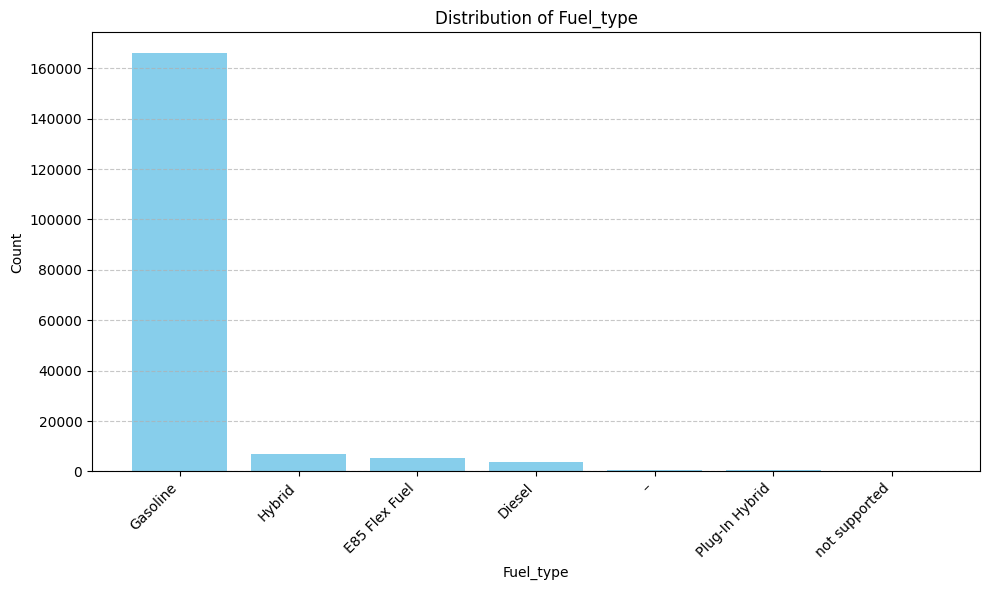


accident Distribution:
                                 accident   Count
0                           None reported  144514
1  At least 1 accident or damage reported   41567


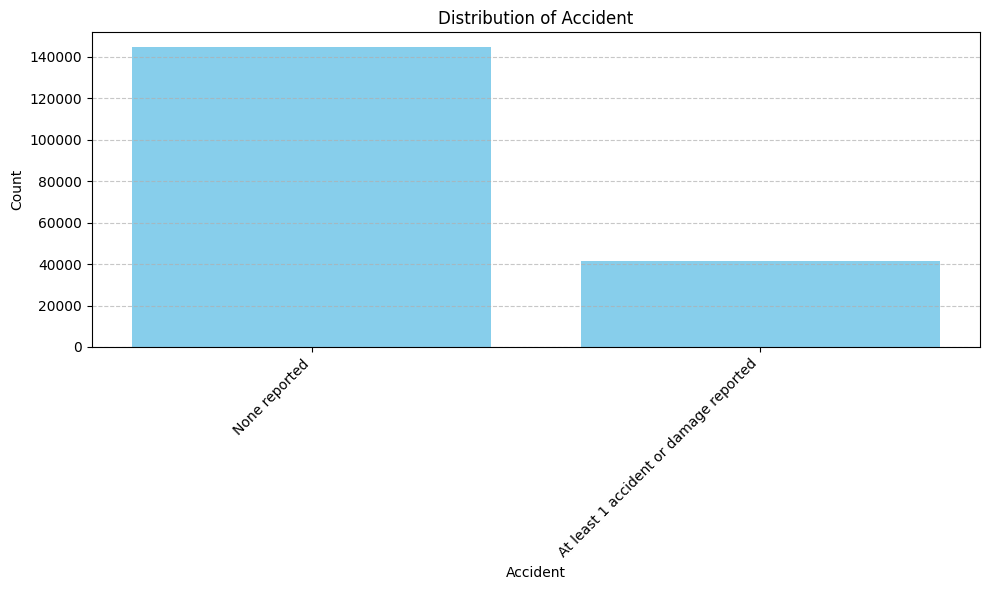


clean_title Distribution:
  clean_title   Count
0         Yes  167114


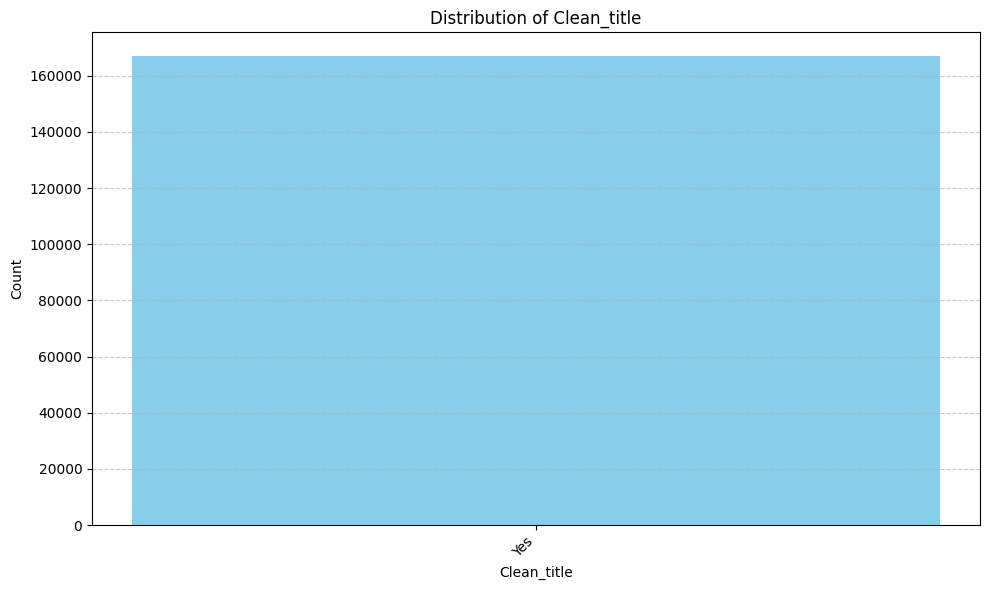

In [21]:
# List of categorical columns to plot
categorical_columns = ['fuel_type', 'accident', 'clean_title']

for column in categorical_columns:
    # Count occurrences of each category
    category_counts = train[column].value_counts()
    
    # Convert to DataFrame for easier plotting
    category_counts_df = pd.DataFrame({
        column: category_counts.index,
        'Count': category_counts.values
    })
    
    # Print the DataFrame
    print(f'\n{column} Distribution:')
    print(category_counts_df)
    
    # Plotting the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(category_counts_df[column], category_counts_df['Count'], color='skyblue')
    
    # Set labels and title
    ax.set_xlabel(column.capitalize())
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {column.capitalize()}')
    
    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels if they are too long
    plt.xticks(rotation=45, ha='right')
    
    # Show plot
    plt.tight_layout()
    plt.show()

The **clean_title** column contains only a single value ('Yes'), so we can drop this column as it will not provide any useful information for our model.

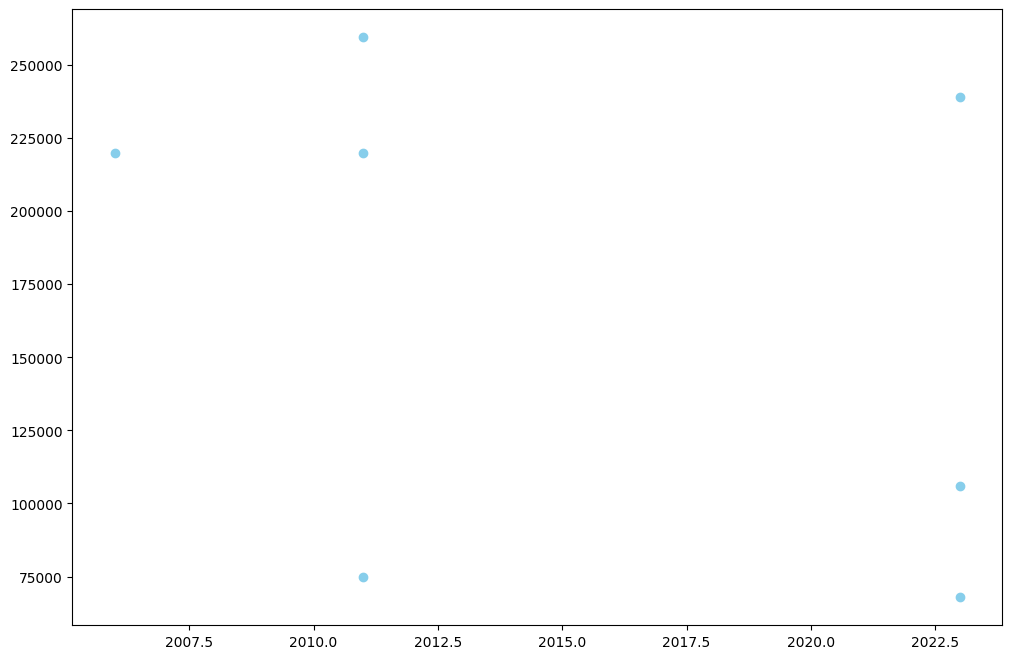

In [22]:
bugatti_data = train[train['brand'] == 'Bugatti']
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(bugatti_data['model_year'], bugatti_data['price'], color='skyblue', label='Bugatti Prices')

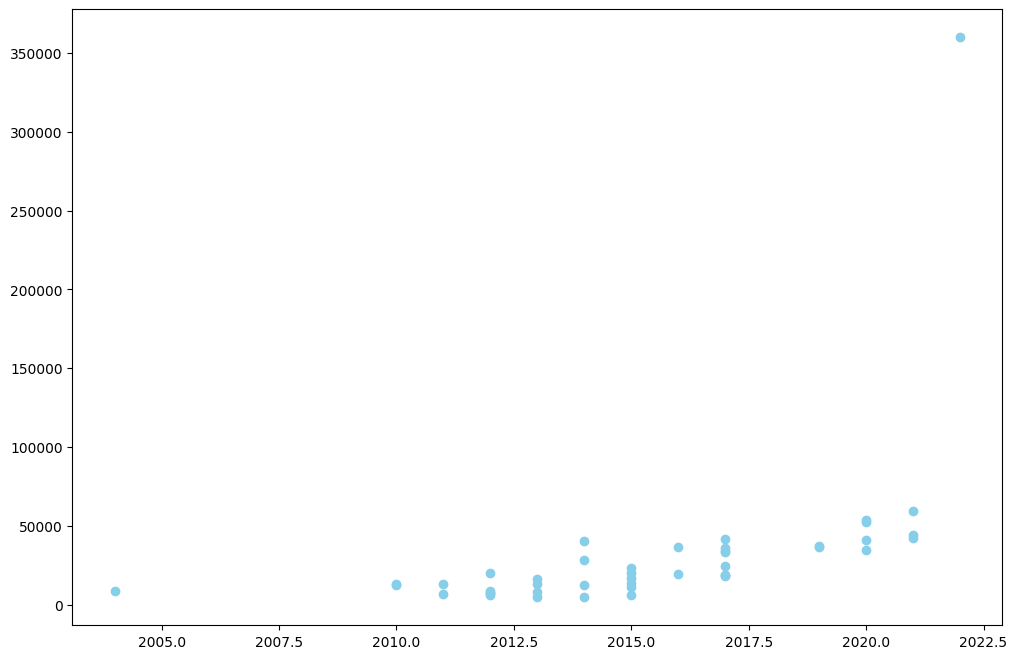

In [23]:
FIAT_data = train[train['brand'] == 'FIAT']
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(FIAT_data['model_year'], FIAT_data['price'], color='skyblue', label='Bugatti Prices')

We can see that the model year does not necessarily determine the price.

        Fuel Type   Count
0        Gasoline  165940
1          Hybrid    6832
2   E85 Flex Fuel    5406
3          Diesel    3955
4               –     781
5  Plug-In Hybrid     521
6   not supported      15


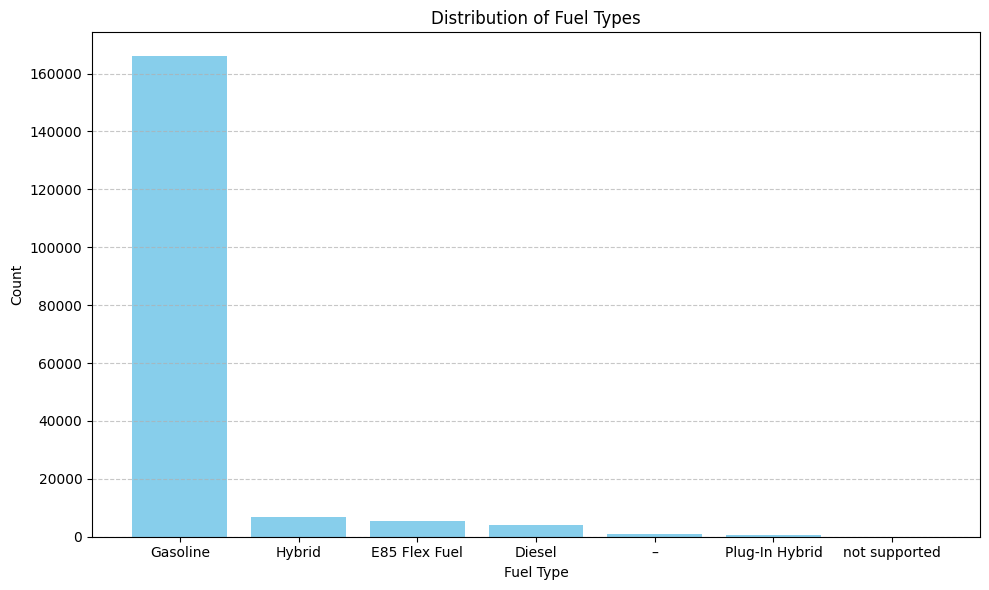

In [24]:
# Count occurrences of each fuel type
fuel_type_counts = train['fuel_type'].value_counts()

# Convert to DataFrame for easier plotting
fuel_type_counts_df = pd.DataFrame({
    'Fuel Type': fuel_type_counts.index,
    'Count': fuel_type_counts.values
})

print(fuel_type_counts_df)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(fuel_type_counts_df['Fuel Type'], fuel_type_counts_df['Count'], color='skyblue')

# Set labels and title
ax.set_xlabel('Fuel Type')
ax.set_ylabel('Count')
ax.set_title('Distribution of Fuel Types')

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

           price    milage
price   1.000000 -0.283067
milage -0.283067  1.000000


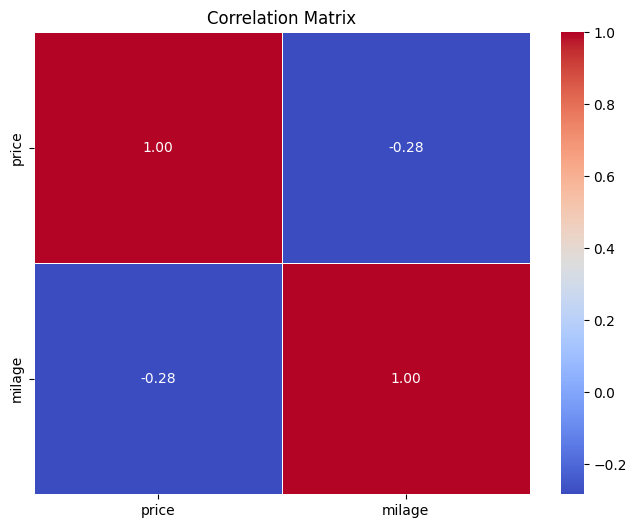

In [25]:
# Calculate correlation matrix
correlation_matrix = train[numerical_columns].corr()

print(correlation_matrix)

# Plot heatmap for correlation matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

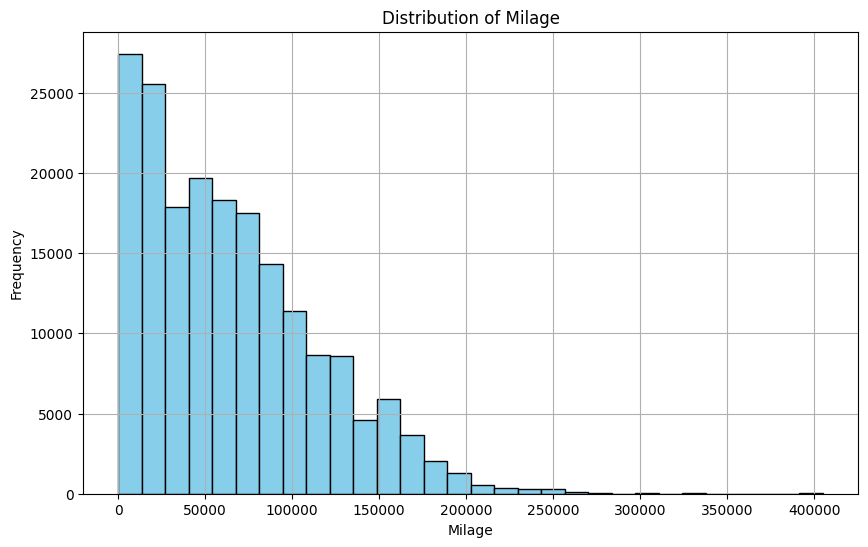

In [26]:
# Plot histogram for milage
plt.figure(figsize=(10, 6))
plt.hist(train['milage'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Milage')
plt.ylabel('Frequency')
plt.title('Distribution of Milage')
plt.grid(True)
plt.show()

From the histogram, we can see that the milage data shows **a positive skew**.


In [27]:
# Compute the average price for each transmission type
average_price_by_transmission = train.groupby('transmission')['price'].mean()

# Identify the transmission with the highest average price
highest_price_transmission = average_price_by_transmission.idxmax()
highest_price_value = average_price_by_transmission.max()

# Identify the transmission with the lowest average price
lowest_price_transmission = average_price_by_transmission.idxmin()
lowest_price_value = average_price_by_transmission.min()

print(f'Transmission with the highest average price: {highest_price_transmission} (${highest_price_value:.2f})')
print(f'Transmission with the lowest average price: {lowest_price_transmission} (${lowest_price_value:.2f})')

Transmission with the highest average price: 7-Speed ($183672.59)
Transmission with the lowest average price: 5-Speed M/T ($16330.05)


# Data Preprocessing 

In [28]:
# Define a function to extract horsepower (HP) and displacement (L) using regular expressions
def extract_engine_info(engine_str):
    # Initialize default values
    horse_power = None
    engine_displacement = None
    
    if pd.notna(engine_str):  # Check if the engine_str is not NaN
        # Extract horsepower (assumed to be followed by 'HP')
        hp_match = re.search(r'(\d+)\s*HP', engine_str)
        if hp_match:
            horse_power = float(hp_match.group(1))  # Get the first matching group and convert to float
        
        # Extract displacement (assumed to be followed by 'L')
        displacement_match = re.search(r'(\d+\.\d+|\d+)\s*L', engine_str)
        if displacement_match:
            engine_displacement = float(displacement_match.group(1))  # Convert to float

    return horse_power, engine_displacement

In [29]:
# Function to extract horsepower from the engine field
def get_horsepower(engine_info):
    try:
        # Find 'HP' and extract the number before it
        if 'HP' in engine_info:
            return float(engine_info.split('HP')[0].strip())
        return None
    except Exception as e:
        print(f"Error extracting horsepower: {e}")
        return None

# Function to extract engine size in liters from the engine field
def get_engine_size(engine_info):
    try:
        # Find 'L' and extract the number before it
        if 'L' in engine_info:
            return float(engine_info.split('L')[0].split()[-1])
        return None
    except Exception as e:
        print(f"Error extracting engine size: {e}")
        return None

In [30]:
train['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [31]:
def data_preprocessing(train, test):
    # Drop the 'clean_title' column if it exists
    if 'clean_title' in train.columns:
        train.drop(columns=['clean_title'], inplace=True)
    if 'clean_title' in test.columns:
        test.drop(columns=['clean_title'], inplace=True)
        
    # Replace missing or unsupported values in 'fuel_type'
    train['fuel_type'] = train['fuel_type'].str.strip().replace(['nan', '–', 'not supported'], 'Unknown')  
    test['fuel_type'] = test['fuel_type'].str.strip().replace(['nan', '–', 'not supported'], 'Unknown')
    
    # Replace 'Blu' with 'Blue' and '–' with 'Unknown' in 'ex_col' of train and test DataFrames
    train['ex_col'] = train['ext_col'].str.strip().replace({'Blu': 'Blue', '–': 'Unknown'})
    test['ex_col'] = test['ext_col'].str.strip().replace({'Blu': 'Blue', '–': 'Unknown'})
    
    # Ensure that the columns are of the correct type
    train = train.astype({
        'brand': 'str', 
        'model': 'str', 
        'fuel_type': 'str', 
        'engine': 'str', 
        'transmission': 'str', 
        'ext_col': 'str', 
        'int_col': 'str', 
        'accident': 'str'
    })
    test = test.astype({
        'brand': 'str', 
        'model': 'str', 
        'fuel_type': 'str', 
        'engine': 'str', 
        'transmission': 'str', 
        'ext_col': 'str', 
        'int_col': 'str', 
        'accident': 'str'
    })
    
    return train, test


In [32]:
train, test = data_preprocessing(train, test)

In [33]:
def feature_engineering(df):
    # vehicle_age
    df['vehicle_age'] = 2024 - df['model_year']
    
    # Avoid division by zero for new vehicles (set vehicle_age to 1 where it is 0)
    df['vehicle_age'] = df['vehicle_age'].replace(0, 1)
    
    # mileage_per_year
    df['mileage_per_year'] = df['milage'] / df['vehicle_age']
    
    df['horse_power'] = df['engine'].apply(get_horsepower)
    df['engine_displacement'] = df['engine'].apply(get_engine_size)

    # engine_power_ratio (handle division by zero)
    df['engine_power_ratio'] = df.apply(lambda row: row['horse_power'] / row['engine_displacement'] 
                                        if pd.notna(row['horse_power']) and pd.notna(row['engine_displacement']) 
                                        and row['engine_displacement'] != 0 else None, axis=1)
    
    # expected_mileage_per_year (if vehicle_age is 0, use 20000 as default value)
    df['expected_mileage_per_year'] = df['vehicle_age'].apply(lambda x: 20000 if x == 1 else x * 20000)
    
    # Determine if the vehicle is overused
    df['overused'] = (df['mileage_per_year'] > df['expected_mileage_per_year']).astype(int)
    
    # Calculate usage ratio and mileage difference
    df['usage_ratio'] = df['mileage_per_year'] / df['expected_mileage_per_year']
    df['mileage_difference'] = df['mileage_per_year'] - df['expected_mileage_per_year']
    
    # Identify luxury brands
    luxury_brands = ['Genesis', 'Mercedes-Benz', 'Audi', 'BMW', 'Tesla', 'Cadillac', 'Volvo', 'Alfa', 
                     'INFINITI', 'Porsche', 'McLaren', 'Lexus', 'Jaguar', 'Acura', 'Rolls-Royce', 
                     'Maserati', 'Bentley', 'Ferrari', 'Aston', 'Lamborghini', 'Lucid', 'Lotus', 
                     'Bugatti', 'Polestar', 'Maybach']
    
    # Flag whether the car brand is a luxury brand
    df['Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    label_encoder = LabelEncoder()
    df['brand_encoded'] = label_encoder.fit_transform(df['brand'])
        
    df['mileage_brand_interaction'] = df['milage'] * df['brand_encoded']

    return df


In [34]:
train['ext_col'].unique()

array(['Yellow', 'Silver', 'Blue', 'Black', 'White',
       'Snowflake White Pearl Metallic', 'Gray', 'Green',
       'Santorini Black Metallic', 'Purple', 'Ebony Twilight Metallic',
       'Red', 'Magnetite Black Metallic', 'Diamond Black', 'Vega Blue',
       'Beige', 'Gold', 'Platinum White Pearl', 'Metallic',
       'White Frost Tri-Coat', 'Firecracker Red Clearcoat',
       'Phytonic Blue Metallic', 'Blu', 'Orange', 'Brown',
       'Brilliant Silver Metallic', 'Black Raven', 'Black Clearcoat',
       'Firenze Red', 'Agate Black Metallic', 'Glacial White Pearl',
       'Majestic Plum Metallic', 'designo Diamond White Metallic',
       'Oxford White', 'Black Sapphire Metallic', 'Mythos Black',
       'Granite Crystal Clearcoat Metallic', 'White Diamond Tri-Coat',
       'Magnetite Gray Metallic', 'Carpathian Grey Premium Metallic',
       'designo Diamond White Bright',
       'Phantom Black Pearl Effect / Black Roof', 'Nebula Gray Pearl',
       'Deep Crystal Blue Mica', 'Flame Red

* Vehicle Age means the numerical diEEerence between the current calendar year and the vehicle model year.
https://www.lawinsider.com/dictionary/vehicle-age#:~:text=Vehicle%20Age%20means%20the%20numerical,and%20the%20vehicle%20model%20year.

In [35]:
train = feature_engineering(train)
test = feature_engineering(test)

In [36]:
numerical_columns = train.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns.tolist()
numerical_columns =  [column for column in numerical_columns if column != 'id']
numerical_columns

['model_year',
 'milage',
 'price',
 'vehicle_age',
 'mileage_per_year',
 'horse_power',
 'engine_displacement',
 'engine_power_ratio',
 'expected_mileage_per_year',
 'overused',
 'usage_ratio',
 'mileage_difference',
 'Luxury_Brand',
 'brand_encoded',
 'mileage_brand_interaction']

In [37]:
categorical_columns = ['brand', 'model', 'fuel_type', 'accident', 'engine', 'transmission', 'ext_col', 'int_col']

In [38]:
# คำนวณ correlation ของคอลัมน์ตัวเลข
correlation_matrix = train[numerical_columns].corr()

In [39]:
correlation_matrix

,model_year,milage,price,vehicle_age,mileage_per_year,horse_power,engine_displacement,engine_power_ratio,expected_mileage_per_year,overused,usage_ratio,mileage_difference,Luxury_Brand,brand_encoded,mileage_brand_interaction
model_year,1.000000,-0.669936,0.231795,-0.999987,0.150838,0.409144,-0.020012,0.434883,-0.999987,0.097267,0.326339,0.998520,0.063980,-0.014605,-0.458387
milage,-0.669936,1.000000,-0.283067,0.669918,0.415788,-0.438686,-0.014164,-0.420550,0.669918,-0.012525,-0.086865,-0.640574,-0.154903,-0.007286,0.665269
price,0.231795,-0.283067,1.000000,-0.231777,-0.096186,0.276135,0.093090,0.176104,-0.231777,0.025530,0.064659,0.224240,0.085581,0.017657,-0.184011
vehicle_age,-0.999987,0.669918,-0.231777,1.000000,-0.150726,-0.409087,0.019983,-0.434747,1.000000,-0.096760,-0.325959,-0.998527,-0.063918,0.014555,0.458374
mileage_per_year,0.150838,0.415788,-0.096186,-0.150726,1.000000,-0.117823,-0.020737,-0.090080,-0.150726,0.465817,0.735302,0.204132,-0.136677,-0.019940,0.264828
horse_power,0.409144,-0.438686,0.276135,-0.409087,-0.117823,1.000000,0.605289,0.329230,-0.409087,0.045042,0.105118,0.399198,0.179662,-0.052056,-0.336441
engine_displacement,-0.020012,-0.014164,0.093090,0.019983,-0.020737,0.605289,1.000000,-0.508526,0.019983,0.004162,0.008228,-0.020922,-0.166113,-0.083295,-0.063459
engine_power_ratio,0.434883,-0.420550,0.176104,-0.434747,-0.090080,0.329230,-0.508526,1.000000,-0.434747,0.022519,0.078364,0.426041,0.377880,-0.060316,-0.306848
expected_mileage_per_year,-0.999987,0.669918,-0.231777,1.000000,-0.150726,-0.409087,0.019983,-0.434747,1.000000,-0.096760,-0.325959,-0.998527,-0.063918,0.014555,0.458374
overused,0.097267,-0.012525,0.025530,-0.096760,0.465817,0.045042,0.004162,0.022519,-0.096760,1.000000,0.700616,0.121379,-0.011734,0.001219,-0.005528


# Modelling

* **Train:**
ใช้ข้อมูลการฝึก (training data) เพื่อฝึก (train) โมเดล

* **Predict:**
ใช้ข้อมูลการทดสอบ (test data) เพื่อทำการคาดการณ์ (prediction)

Setting remainder=’passthrough’ will mean that all columns not specified in the list of “transformers” will be passed through without transformation, instead of being dropped.

In [ ]:
# Import necessary libraries
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Separate features (X) and target (y) for training data
X_train = train.drop(columns=['price', 'id'])
y_train = train['price']

# Test set (X_test) should exclude the 'price' column
X_test = test

# Identify categorical and numerical columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X_train.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns.tolist()

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  
            ('scaler', RobustScaler())  
        ]), numerical_columns),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))     
        ]), categorical_columns)
    ],
    remainder='passthrough'
)

# Best parameters for LightGBM and CatBoost
lightgbm_best_params = {
    'n_estimators': 1211,
    'num_leaves': 190,
    'max_depth': 19,
    'cat_smooth': 70,
    'learning_rate': 0.003801963559426788,
    'subsample': 0.5752183915521658,
    'colsample_bytree': 0.45828300427468893,
    'min_split_gain': 0.007998450841220002,
    'min_child_weight': 70,
    'reg_lambda': 7.517808763714647e-10, # Use reg_lambda instead of lambda_l2
    'reg_alpha': 0.0002700842614201799, # Use reg_alpha instead of lambda_l1
    'max_bin': 926
}

# lightgbm_best_params = {
#     'n_estimators': 100,  # Start with fewer trees
#     'num_leaves': 30,     # Fewer leaves
#     'max_depth': 10,      # Shallower trees
#     'learning_rate': 0.01,  # Slightly higher learning rate
#     'subsample': 0.8,     # More samples for each tree
#     'colsample_bytree': 0.8,
#     'min_split_gain': 0.01,
#     'min_child_weight': 1,
#     'reg_lambda': 1,      # Adjust regularization
#     'reg_alpha': 0.1,
#     'max_bin': 255        # Adjust number of bins
# }

catboost_best_params = {
    'iterations': 1211,
    'depth': 8,
    'learning_rate': 0.0059235893233413415,
    'l2_leaf_reg': 5.190883844082656,
    'random_strength': 2.8335733900492563,
    'bagging_temperature': 0.7186471837171271,
    'border_count': 157,
    'min_data_in_leaf': 209,
    'random_seed': 42,
    'verbose': False
}

from sklearn.preprocessing import StandardScaler

# Base models for stacking with tuned hyperparameters
estimators = [
    ('linear_reg', Pipeline(steps=[
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())  # Use StandardScaler for normalization
                ]), numerical_columns),
                
                ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), categorical_columns)
            ],
            remainder='passthrough'
        )),
        ('model', LinearRegression())  # No parameters for Linear Regression
    ])),
    
    ('lightgbm', Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(**lightgbm_best_params))
    ])),
    
    ('catboost', Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(**catboost_best_params))
    ]))
]

# Meta-learner for stacking
stacking_regressor = StackingRegressor(
    estimators=estimators, 
    final_estimator=LinearRegression()  # Linear Regression as the meta-learner
)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(stacking_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive values for interpretation
mse_scores = -cv_scores

# Display results
print(f"Cross-Validation MSE scores: {mse_scores}")
print(f"Mean MSE: {mse_scores.mean()}")
print(f"Standard Deviation of MSE: {mse_scores.std()}")

# Fit the stacked model on the entire training set
stacking_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_regressor.predict(X_test)
print(f"Test set predictions: {y_pred[:10]}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.033421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 2760
[LightGBM] [Info] Start training from score 43859.547492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

# Submission

In [ ]:
ids = test['id']  
predictions = y_pred  # Predictions

# Create a DataFrame for submission
submission = pd.DataFrame({
    'id': ids,
    'price': predictions
})

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False) 